# Hyperparameter Tuning in Decision Trees

Adjusted from [Kaggle](https://www.kaggle.com/code/gauravduttakiit/hyperparameter-tuning-in-decision-trees/notebook)

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

%matplotlib inline

## Inspect Data

In [219]:
# Load data
df = pd.read_csv("heart_v2.csv")

In [220]:
df.columns

Index(['age', 'sex', 'BP', 'cholestrol', 'heart disease'], dtype='object')

In [221]:
df.head()

,age,sex,BP,cholestrol,heart disease
0,70,1,130,322,1
1,67,0,115,564,0
2,57,1,124,261,1
3,64,1,128,263,0
4,74,0,120,269,0


In [222]:
df.shape

(270, 5)

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            270 non-null    int64
 1   sex            270 non-null    int64
 2   BP             270 non-null    int64
 3   cholestrol     270 non-null    int64
 4   heart disease  270 non-null    int64
dtypes: int64(5)
memory usage: 10.7 KB


In [224]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,270.0,54.433333,9.109067,29.0,48.0,55.0,61.0,77.0
sex,270.0,0.677778,0.468195,0.0,0.0,1.0,1.0,1.0
BP,270.0,131.344444,17.861608,94.0,120.0,130.0,140.0,200.0
cholestrol,270.0,249.659259,51.686237,126.0,213.0,245.0,280.0,564.0
heart disease,270.0,0.444444,0.497827,0.0,0.0,0.0,1.0,1.0


## Start Modeling

In [225]:
# Set features
X = df.drop('heart disease',axis=1)

# Set target
y = df['heart disease']

In [226]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)
X_train.shape, X_test.shape

((162, 4), (108, 4))

**Important hyperparameters:**
* min_samples_split (min number of samples required to grow the tree)
* max_depth (control overfitting)
* max_leaf_nodes (control overfitting)
* class_weight (set weights for imbalanced data)

**Fitting the decision tree with default hyperparameters, apart from max_depth which is 3 so that we can plot and read the tree**

In [227]:
# Instantiate and fit model
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

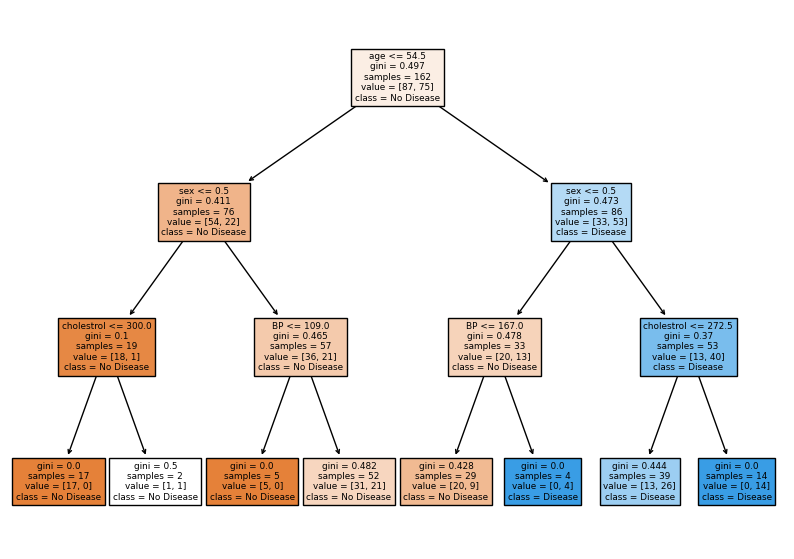

In [228]:
# Plot tree
plt.figure(figsize=(10,7))
tree.plot_tree(dt, feature_names=X.columns, class_names=['No Disease', "Disease"], filled=True);

**Comments:**

* **Feature importance** is determined by **gini index**
* Feature in **ROOT Node** has highest gini index (here: age), all following nodes have features with decreasing gini indeces

* Evaluation of **Decision or Internal Node** condition: If condition is **TRUE go LEFT** in the tree, if condition is **FALSE go RIGHT** in the tree
* Nodes w/o condition are **Leaf or Terminal Nodes**

* 'samples = 162': total samples in that node
* ‘value = [87, 75]’ describes the repartition of the target, i.e. 87 for 'No Disease' (0) and 75 for 'Disease' (1)
* ‘class = No Disease’: This is the condition predicted by that node

## Evaluating model performance

In [229]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [230]:
print(F"Train Accuracy {accuracy_score(y_train, y_train_pred):.2f}")
confusion_matrix(y_train, y_train_pred)

Train Accuracy 0.73


array([[74, 13],
       [31, 44]], dtype=int64)

In [231]:
print(F"Test Accuracy {accuracy_score(y_test, y_test_pred):.2f}")
confusion_matrix(y_test, y_test_pred)

Test Accuracy 0.65


array([[48, 15],
       [23, 22]], dtype=int64)

**Create helper functions to evaluate model performance and help plot the decision tree**

In [232]:
def get_dt_graph(dt_classifier):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(dt_classifier,
                       feature_names=X.columns,
                       class_names=['No Disease', "Disease"],
                       filled=True)

In [233]:
def evaluate_model(dt_classifier):
    print(f"Train Accuracy {accuracy_score(y_train, dt_classifier.predict(X_train)):.2f}")
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print(F"Test Accuracy {accuracy_score(y_test, dt_classifier.predict(X_test)):.2f}")
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

## Without setting any hyperparameters

In [234]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

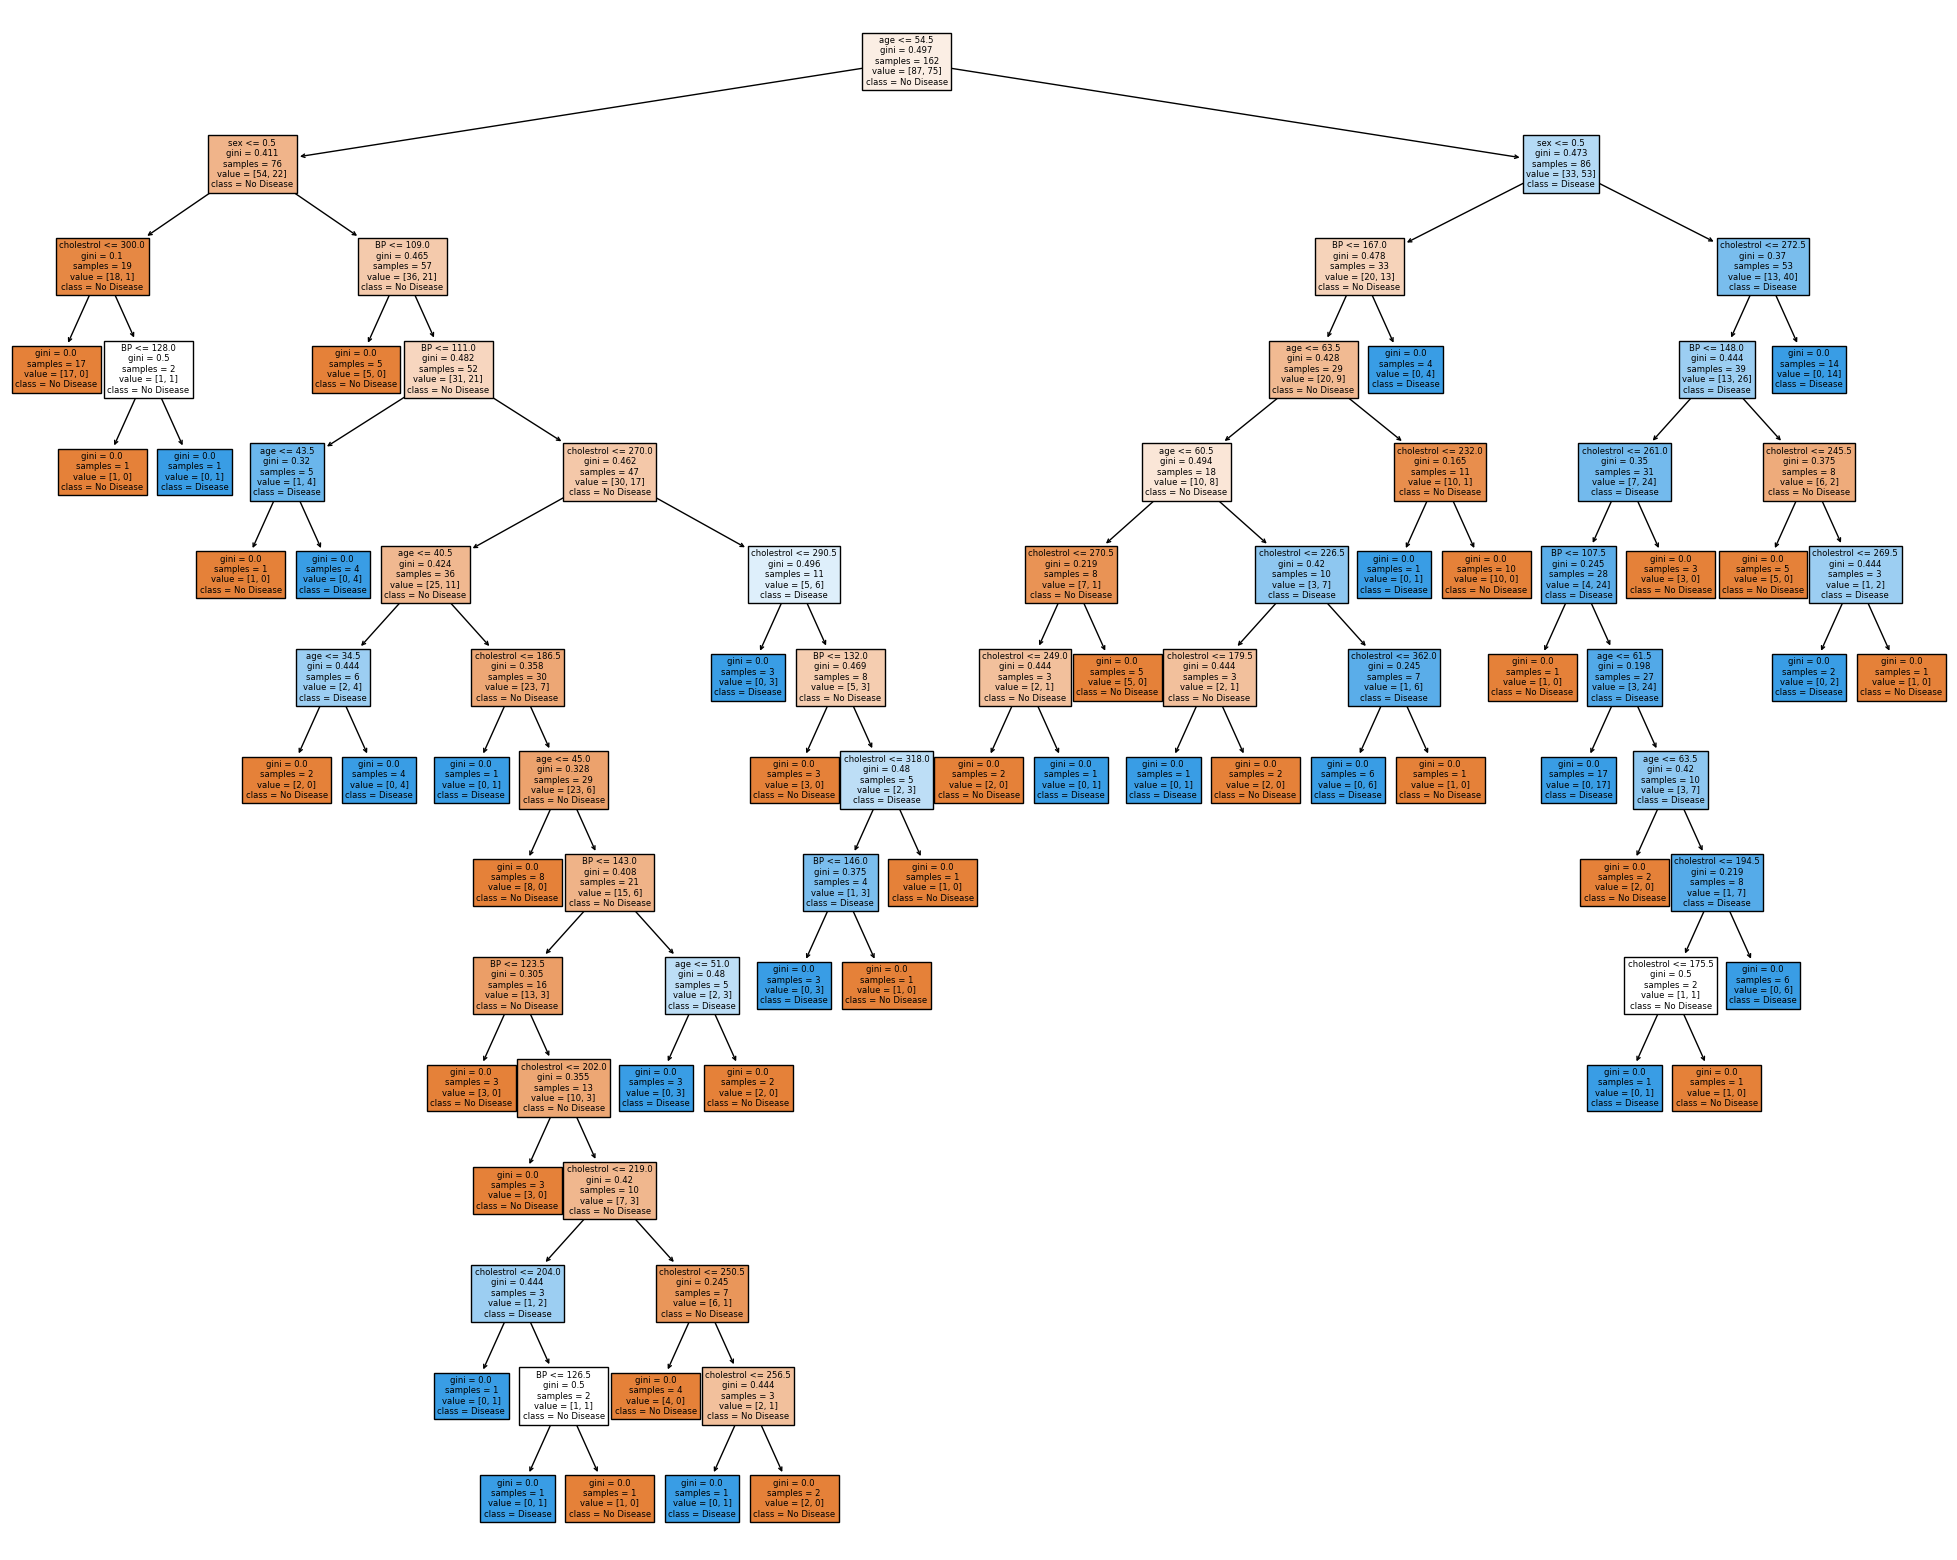

In [235]:
# Plot tree
get_dt_graph(dt_default)

In [236]:
evaluate_model(dt_default)

Train Accuracy 1.00
Train Confusion Matrix:
[[87  0]
 [ 0 75]]
--------------------------------------------------
Test Accuracy 0.57
Test Confusion Matrix:
[[34 29]
 [17 28]]


* **Model is over-fitted**

## Controlling the depth of the tree (max_depth)

max_depth: int, default=None

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [237]:
dt_depth = DecisionTreeClassifier(max_depth=3)
dt_depth.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

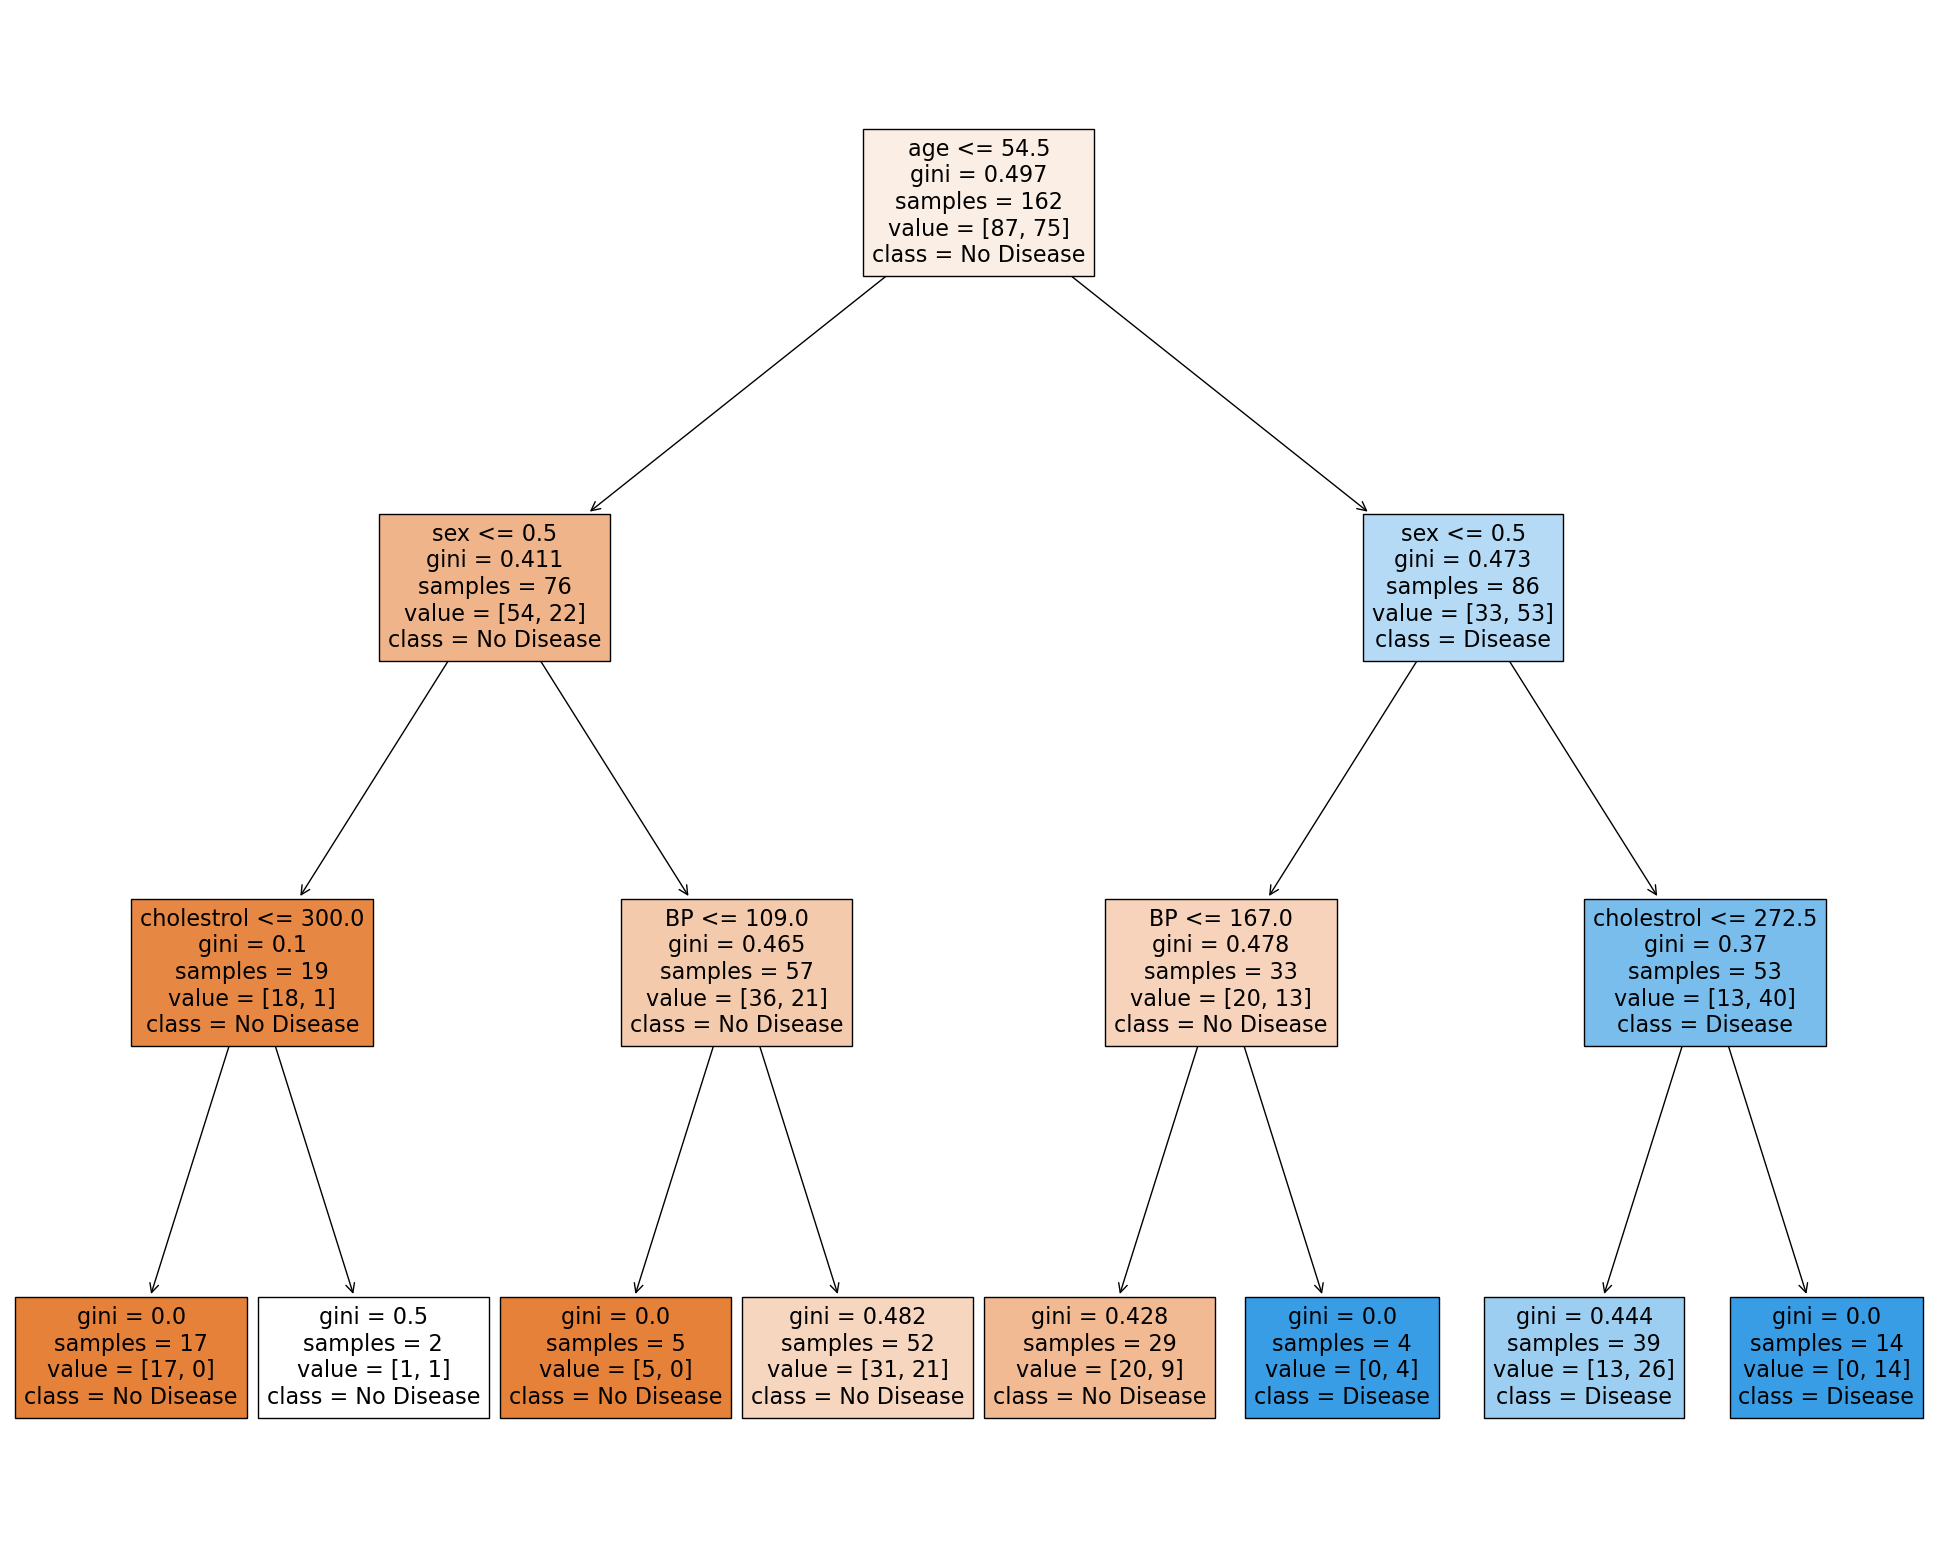

In [238]:
# Plot tree
get_dt_graph(dt_depth) 

In [239]:
evaluate_model(dt_depth)

Train Accuracy 0.73
Train Confusion Matrix:
[[74 13]
 [31 44]]
--------------------------------------------------
Test Accuracy 0.65
Test Confusion Matrix:
[[48 15]
 [23 22]]


## Specifying minimum samples before split (min_samples_split)

min_samples_split: int or float, default=2

The minimum number of samples required to split an internal node

In [240]:
dt_min_split = DecisionTreeClassifier(min_samples_split=20)
dt_min_split.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=20)

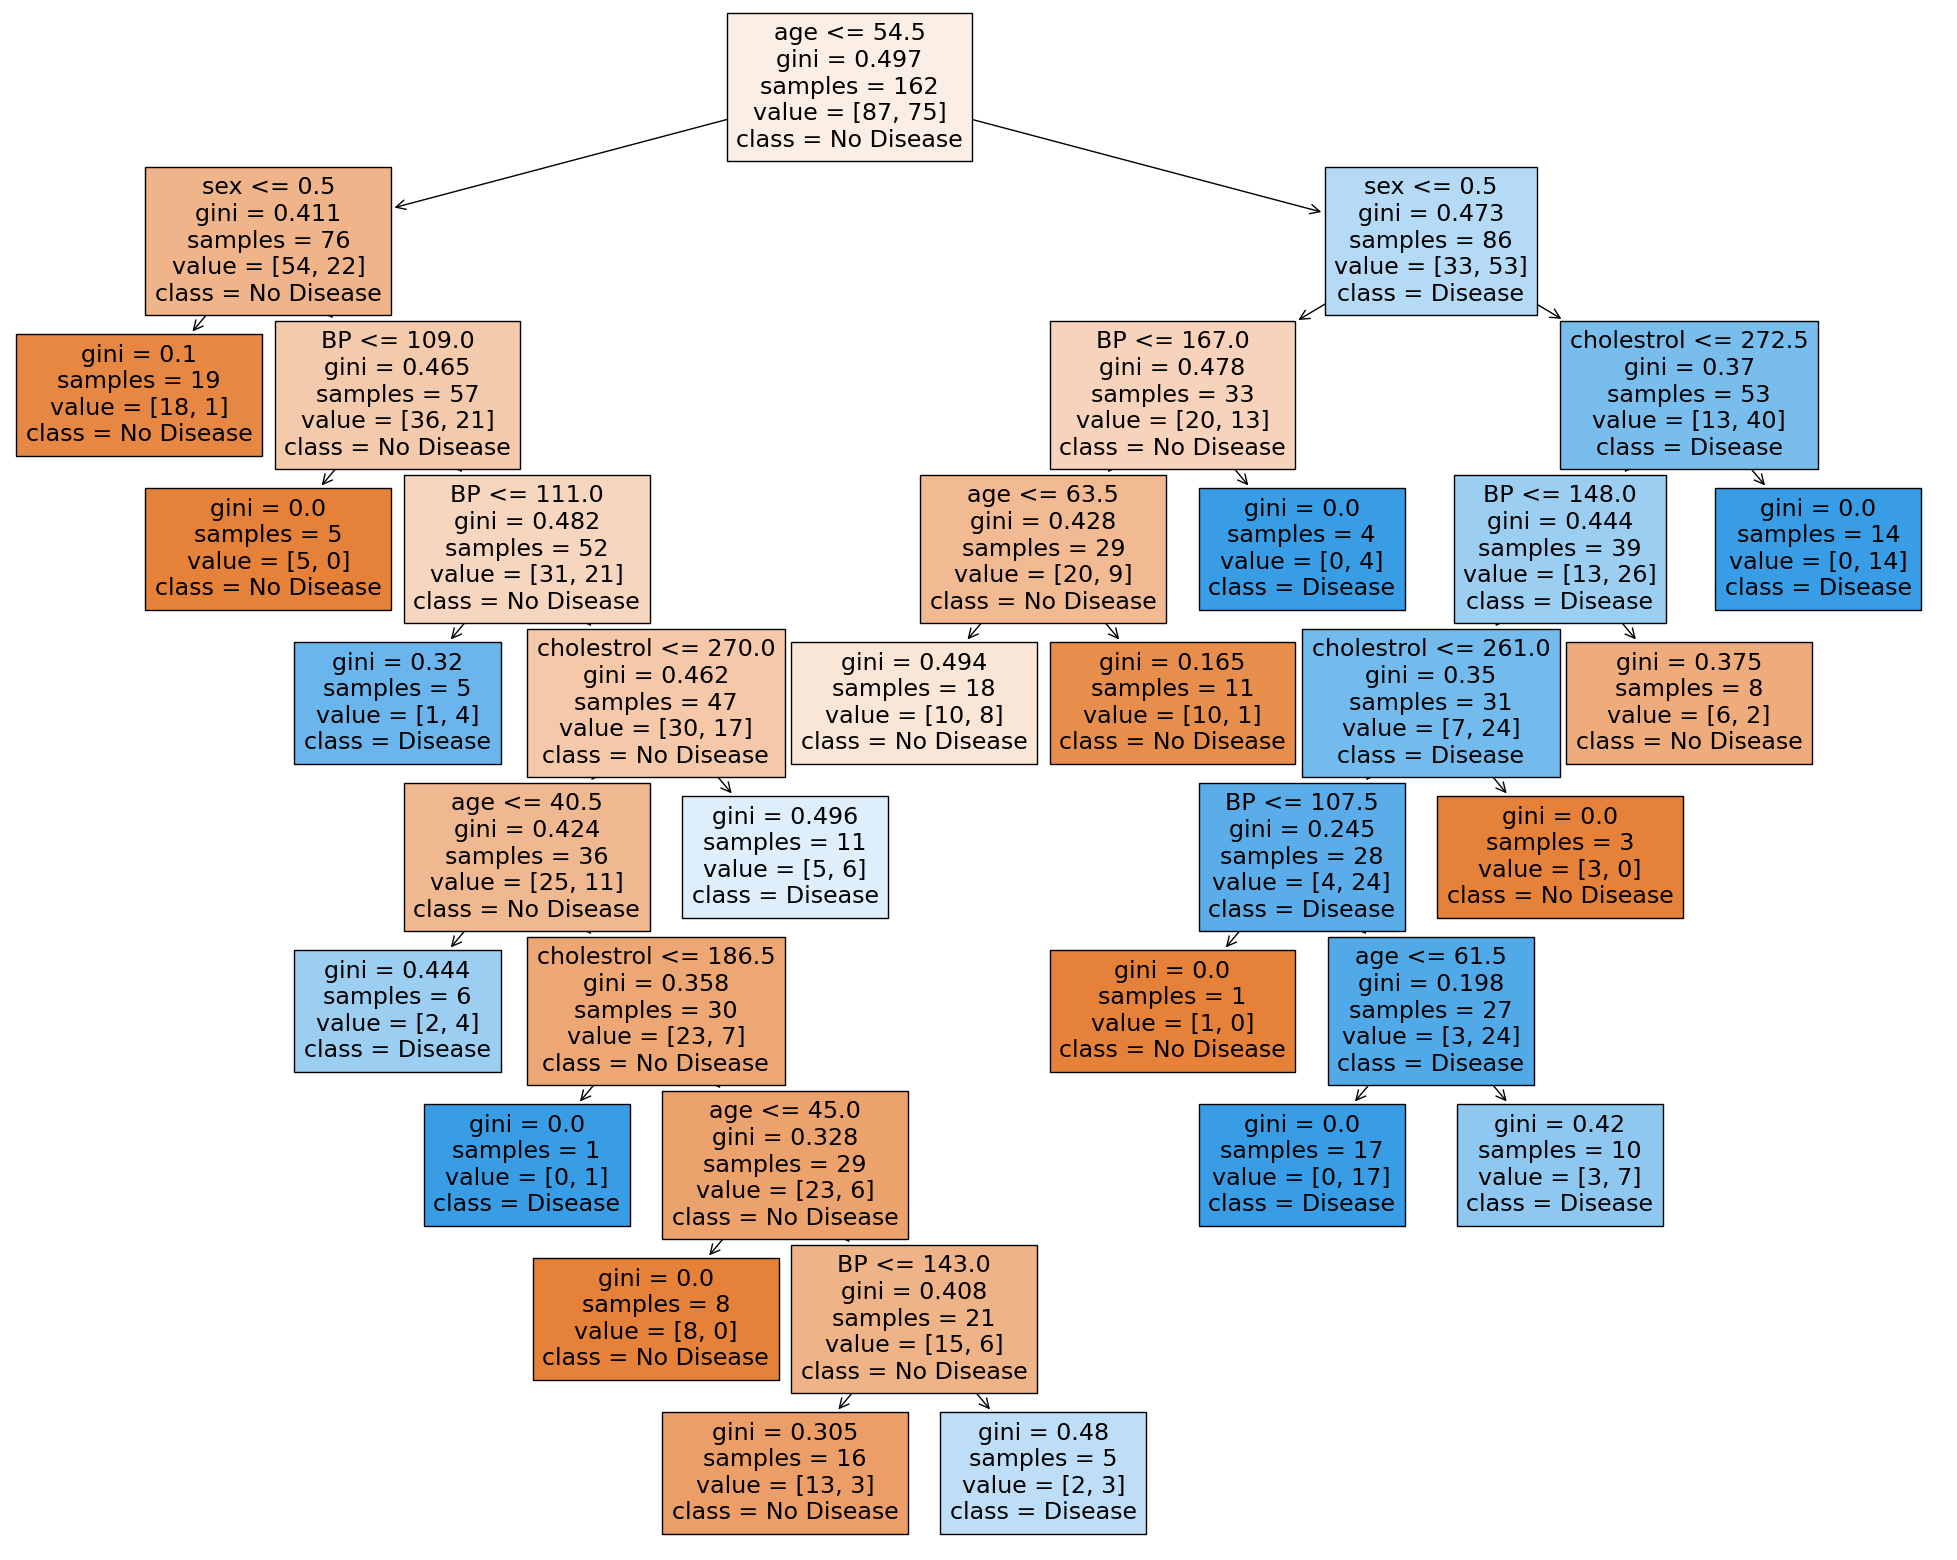

In [241]:
# Plot tree
get_dt_graph(dt_min_split) 

In [242]:
evaluate_model(dt_min_split)

Train Accuracy 0.83
Train Confusion Matrix:
[[74 13]
 [15 60]]
--------------------------------------------------
Test Accuracy 0.64
Test Confusion Matrix:
[[41 22]
 [17 28]]


## Specifying minimum samples in leaf node (min_samples_leaf)

min_samples_leaf: int or float, default=1

The minimum number of samples required to be at a leaf node

In [243]:
dt_min_leaf = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
dt_min_leaf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

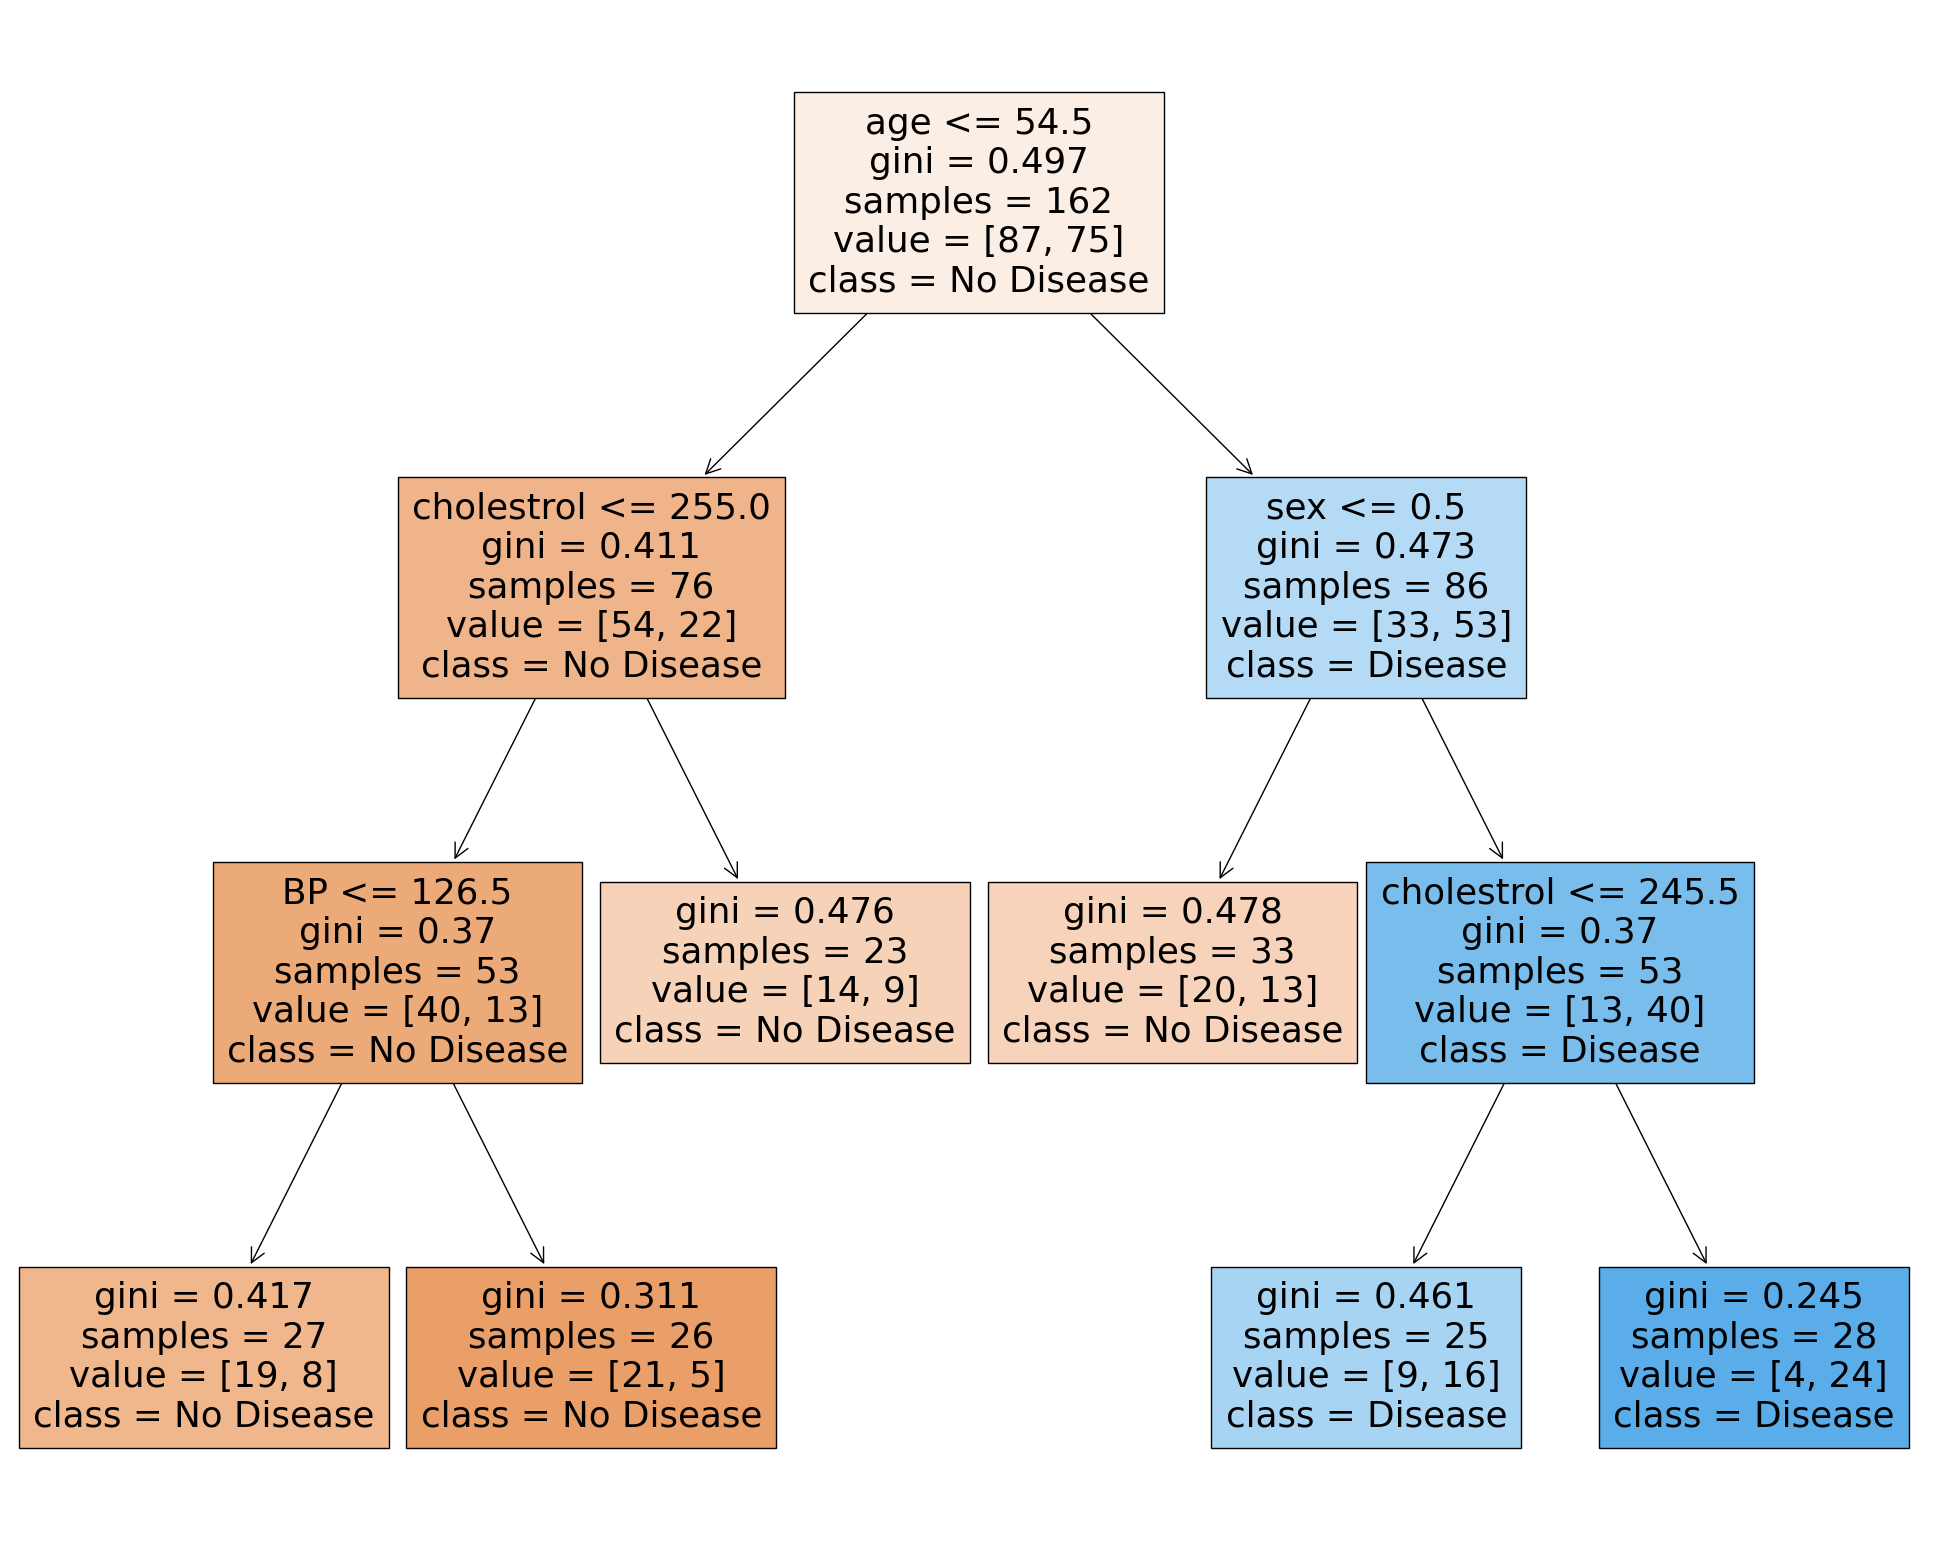

In [244]:
# Plot tree
get_dt_graph(dt_min_leaf)

In [245]:
evaluate_model(dt_min_leaf)

Train Accuracy 0.70
Train Confusion Matrix:
[[74 13]
 [35 40]]
--------------------------------------------------
Test Accuracy 0.66
Test Confusion Matrix:
[[49 14]
 [23 22]]


## Using Entropy instead of Gini

In [246]:
dt_min_leaf_entropy = DecisionTreeClassifier(min_samples_leaf=20, random_state=42, criterion="entropy")
dt_min_leaf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20,
                       random_state=42)

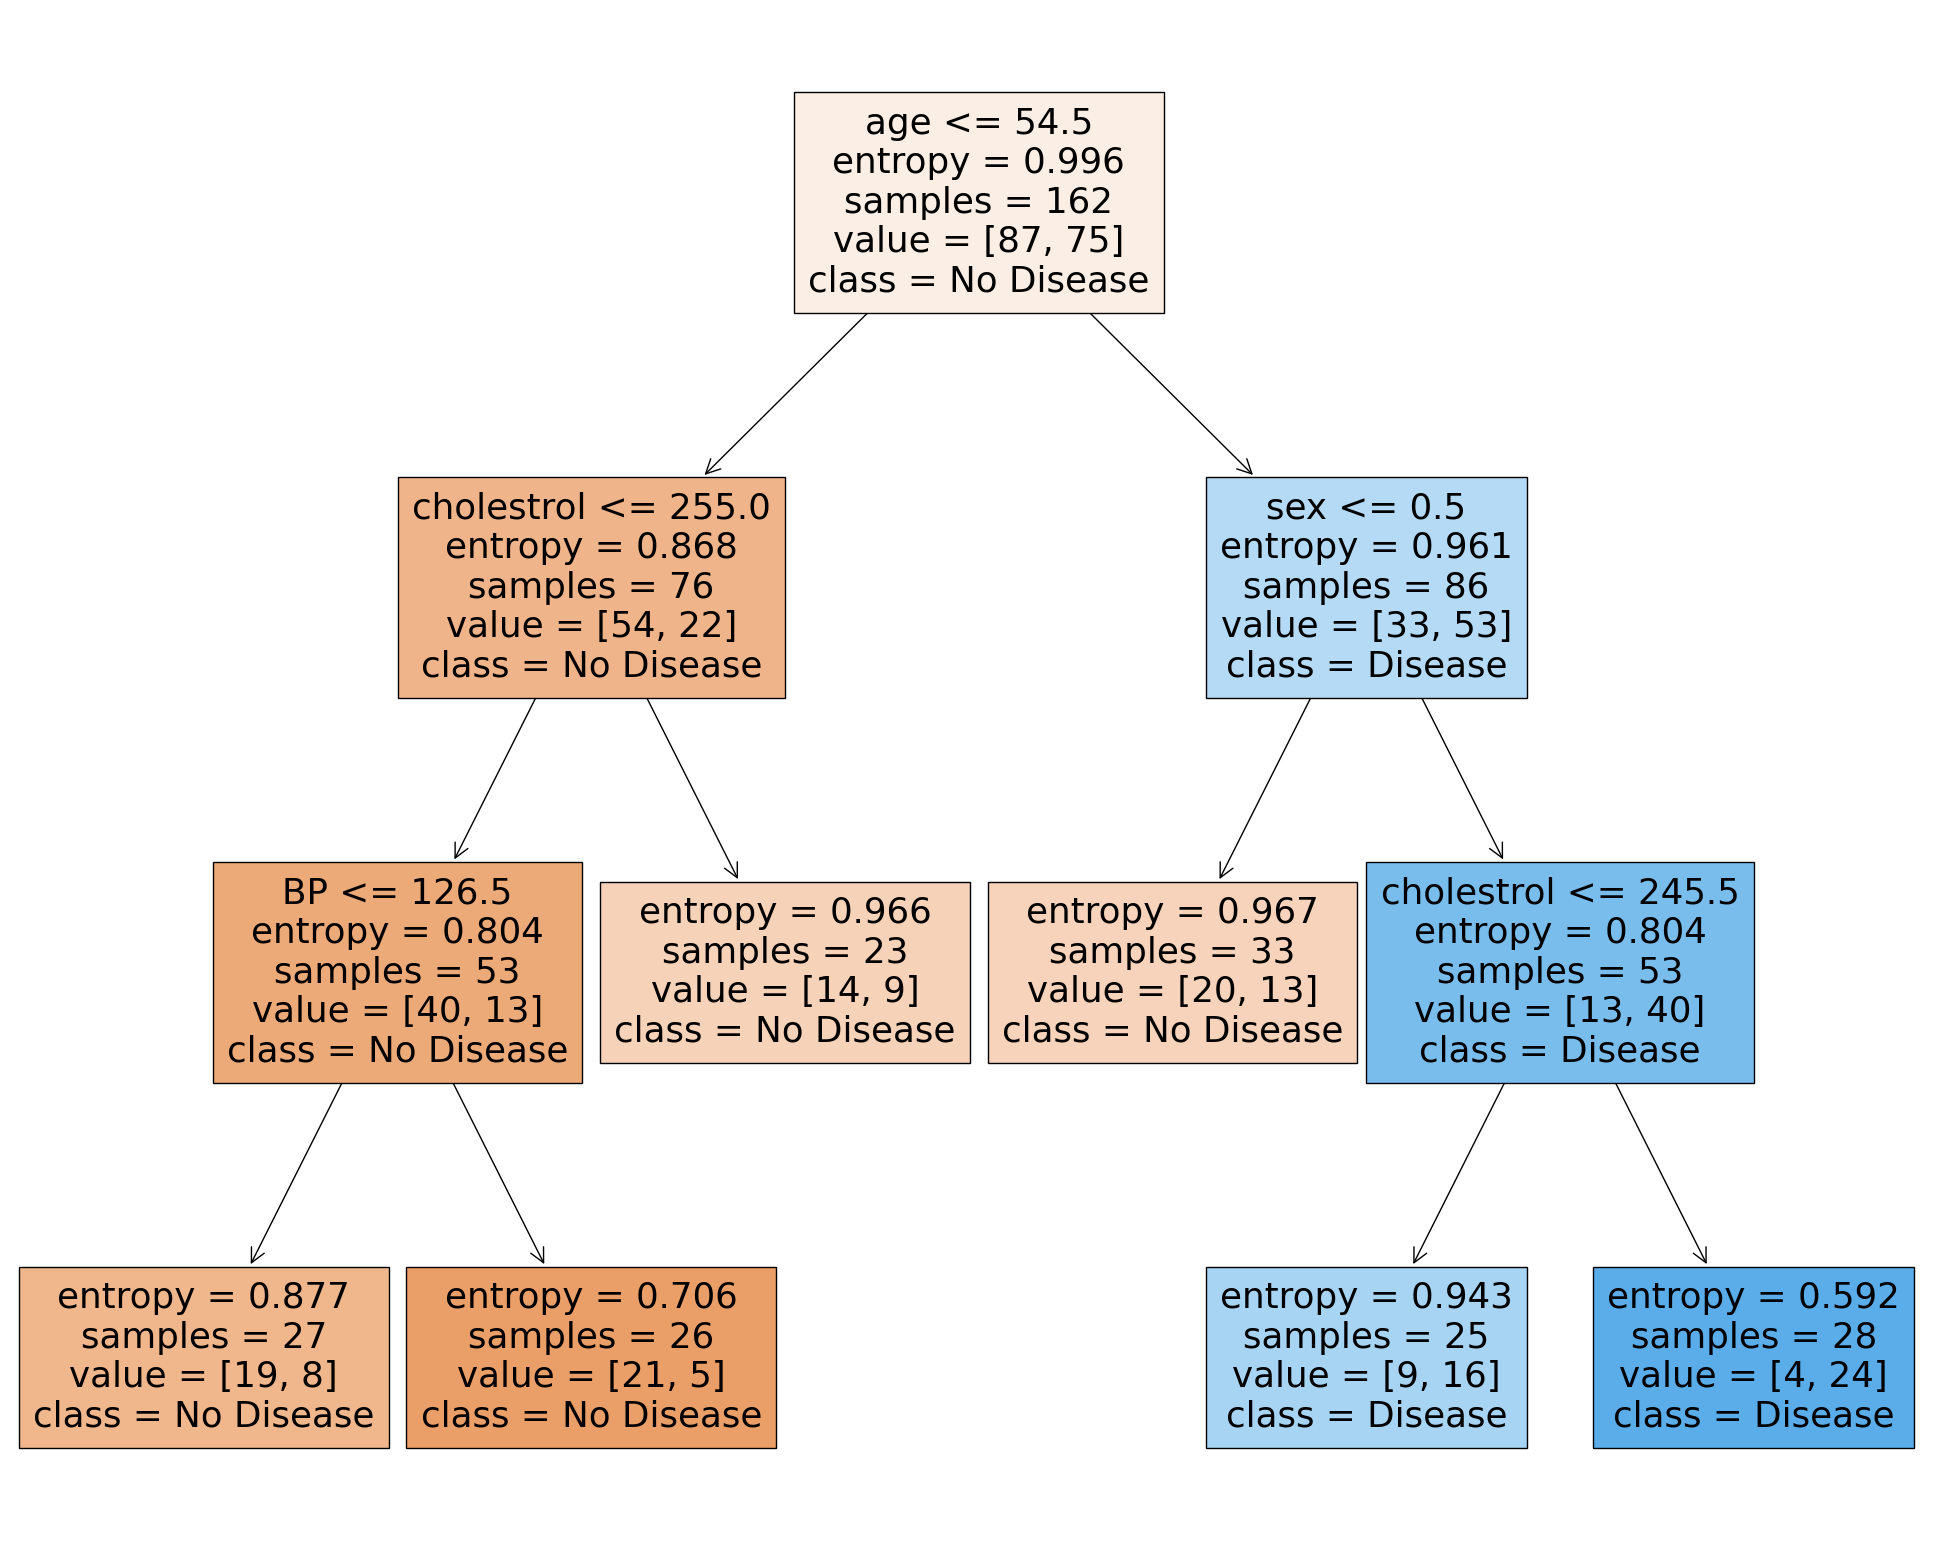

In [247]:
# Plot tree
get_dt_graph(dt_min_leaf_entropy)

In [248]:
evaluate_model(dt_min_leaf_entropy)

Train Accuracy 0.70
Train Confusion Matrix:
[[74 13]
 [35 40]]
--------------------------------------------------
Test Accuracy 0.66
Test Confusion Matrix:
[[49 14]
 [23 22]]


## Hyperparameter tuning

In [249]:
dt = DecisionTreeClassifier(random_state=42)

In [250]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [251]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [252]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Wall time: 4.75 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [253]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005536,0.002062,0.003343,0.000451,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.658537,0.658537,0.550,0.725,0.648018,0.062760,11
1,0.005023,0.000953,0.003693,0.000795,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.658537,0.658537,0.550,0.725,0.648018,0.062760,11
2,0.004665,0.000335,0.003251,0.000433,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.658537,0.682927,0.700,0.725,0.691616,0.024262,1
3,0.004118,0.000205,0.002882,0.000204,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.658537,0.609756,0.575,0.700,0.635823,0.047470,19
4,0.004000,0.000001,0.002500,0.000500,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.536585,0.536585,0.525,0.550,0.537043,0.008851,41


In [254]:
score_df.nlargest(5, "mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,0.004665,0.000335,0.003251,0.000433,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.658537,0.682927,0.7,0.725,0.691616,0.024262,1
7,0.003638,0.000666,0.002613,0.000420,gini,3,20,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.658537,0.682927,0.7,0.725,0.691616,0.024262,1
12,0.003693,0.000411,0.002309,0.000410,gini,5,20,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.658537,0.682927,0.7,0.725,0.691616,0.024262,1
17,0.003576,0.000505,0.002462,0.000464,gini,10,20,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.658537,0.682927,0.7,0.725,0.691616,0.024262,1
22,0.002999,0.000001,0.002017,0.000029,gini,20,20,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.658537,0.682927,0.7,0.725,0.691616,0.024262,1


In [255]:
# Best parameters
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_leaf=20, random_state=42)

In [256]:
dt_best = grid_search.best_estimator_

In [257]:
# Evaluate model with best parameter
evaluate_model(dt_best)

Train Accuracy 0.70
Train Confusion Matrix:
[[74 13]
 [35 40]]
--------------------------------------------------
Test Accuracy 0.66
Test Confusion Matrix:
[[49 14]
 [23 22]]


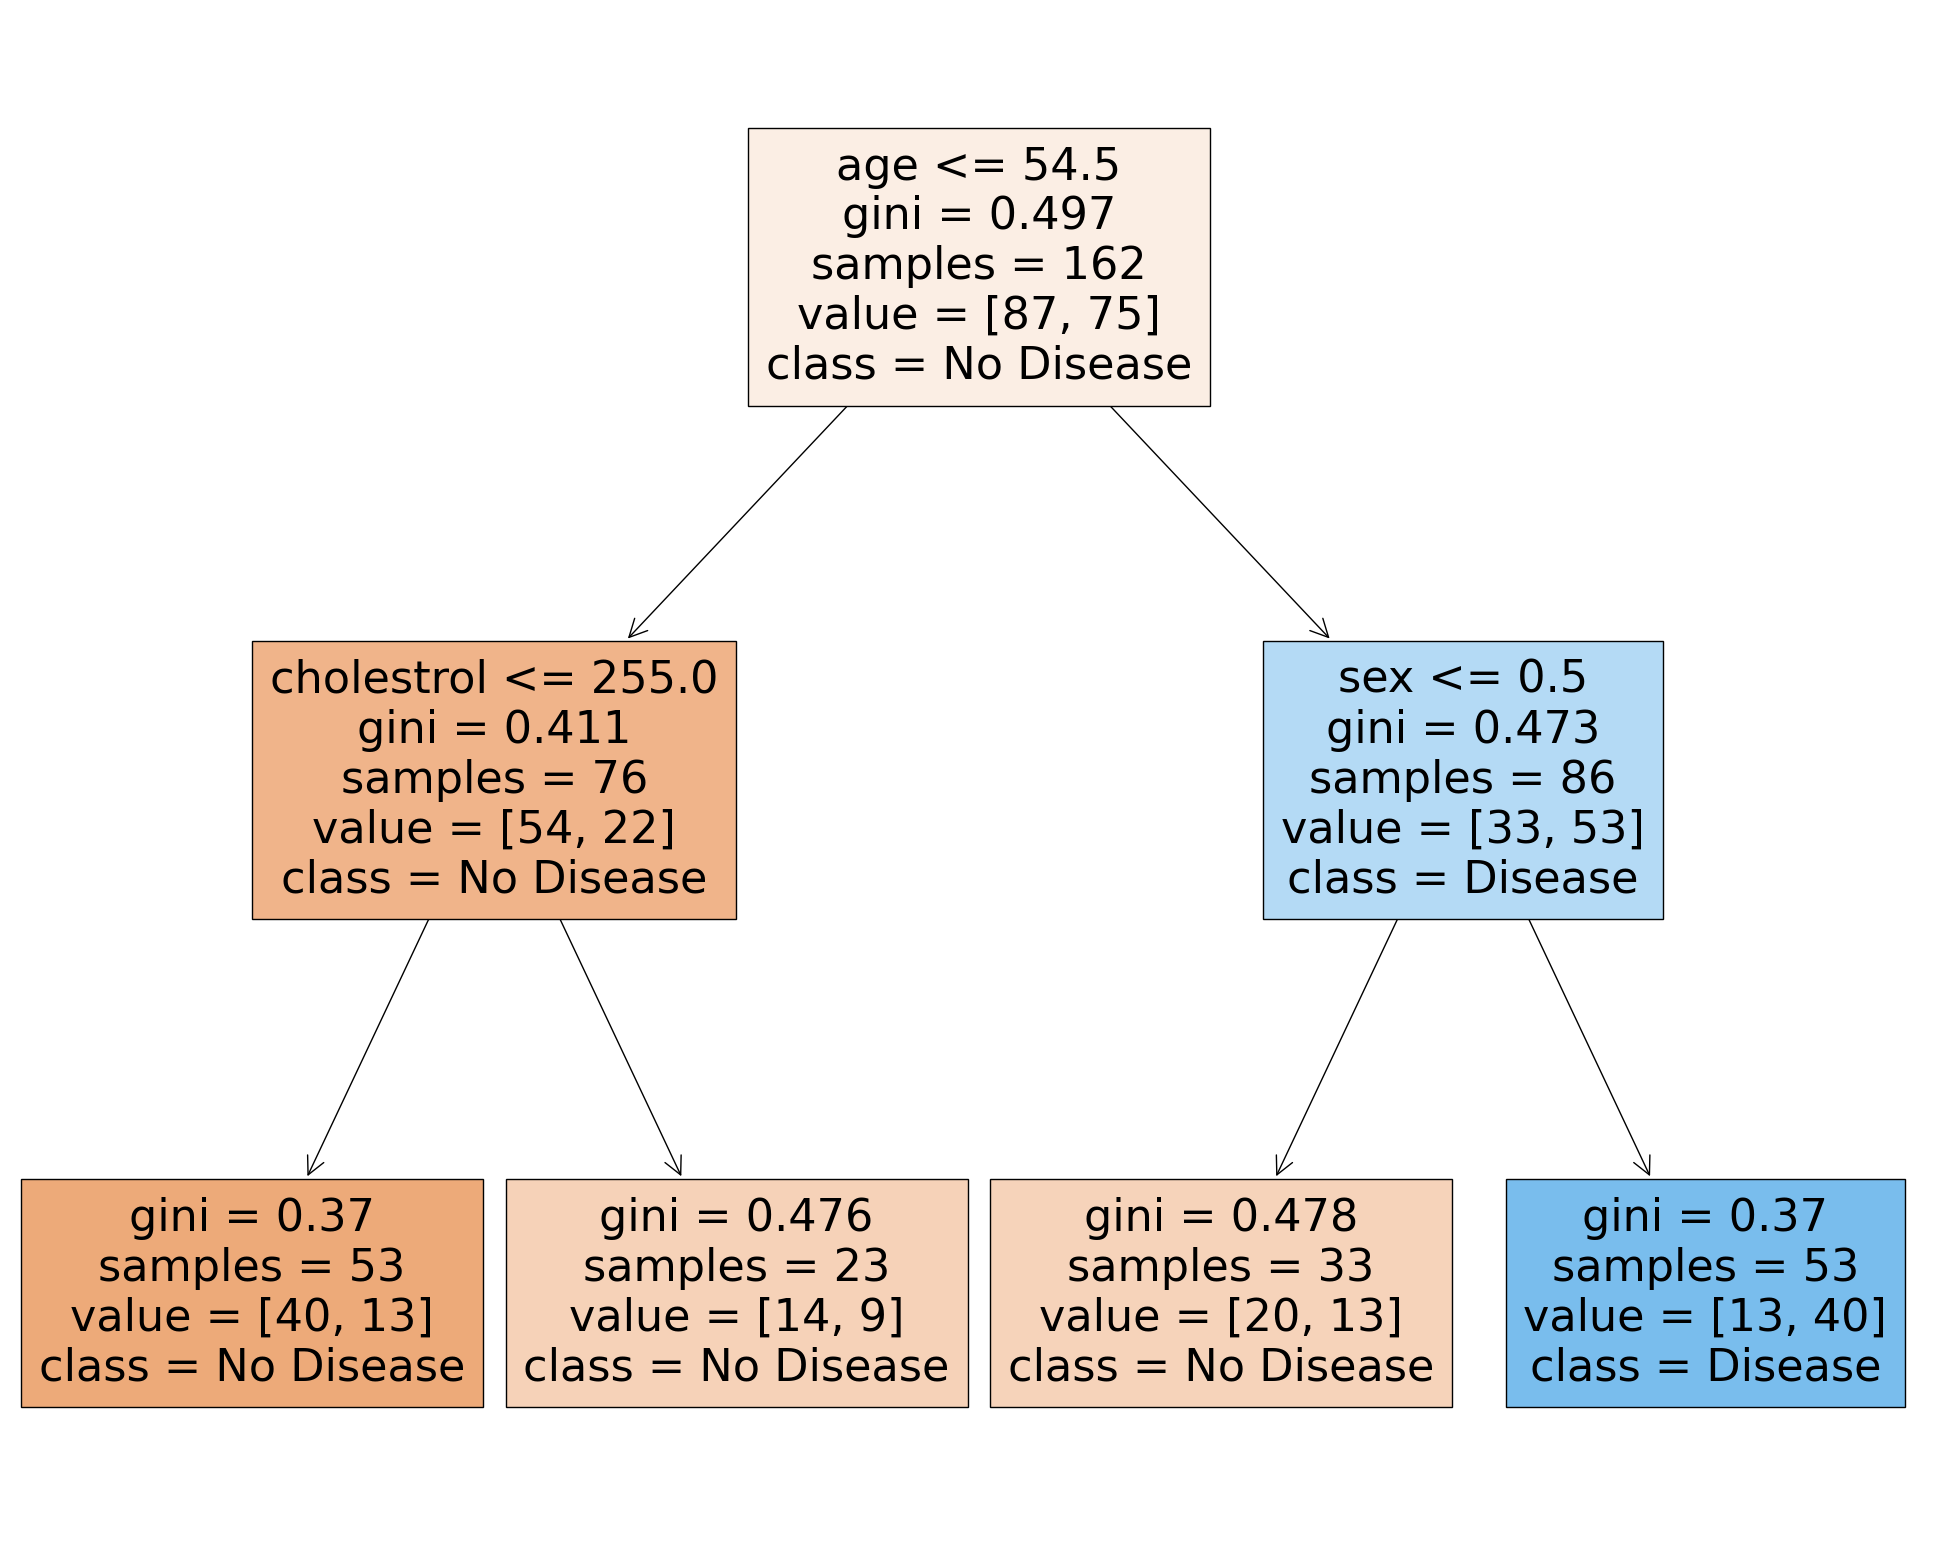

In [258]:
# Plot tree
get_dt_graph(dt_best)

In [259]:
# Classification report
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73        63
           1       0.61      0.49      0.54        45

    accuracy                           0.66       108
   macro avg       0.65      0.63      0.63       108
weighted avg       0.65      0.66      0.65       108

